
# **BB84 Hackathon — Presentation-Ready Colab (SUPER CLEAR)**
**BB84 → Sifting → QBER (4 scenarios incl. noise) → Sampling → Easy Reconcile → Privacy Amplify → AES-GCM (+15-min rotation) → Secure Emoji Split**

> **Note:** The QBER chart demonstrates both ideal and noisy channels.  
> For the rest of the pipeline we continue with the **ideal, No-Eve** data so all outputs are **perfect** and easy to screenshot.



## 0) Colab Setup
Expected: installs succeed.


In [1]:

!pip -q install qiskit qiskit-aer numpy matplotlib cryptography


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00



## 1) Imports & Reproducibility


In [2]:

import numpy as np, math, os, time, random
import matplotlib.pyplot as plt
from hashlib import sha256

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.ciphers.aead import AESGCM

RNG_SEED = 1001
rng = np.random.default_rng(RNG_SEED)
np.set_printoptions(edgeitems=12, threshold=40)

sim_ideal = AerSimulator()



## 2) BB84 Primitives (Correct Mapping)


In [3]:

def prepare_alice(bit:int, basis:int) -> QuantumCircuit:
    # Z basis: 0→|0>, 1→|1> (X);  X basis: 0→|+> (H), 1→|-> (H then Z)
    qc = QuantumCircuit(1,1)
    if basis == 0:
        if bit == 1: qc.x(0)
    else:
        qc.h(0)
        if bit == 1: qc.z(0)
    return qc

def measure_in_basis(qc:QuantumCircuit, basis:int):
    if basis == 1: qc.h(0)
    qc.measure(0,0); return qc

def alice_to_bob(bit, a_basis, b_basis, sim=sim_ideal):
    qc = prepare_alice(bit, a_basis)
    measure_in_basis(qc, b_basis)
    return 1 if sim.run(qc, shots=1).result().get_counts().get('1',0)==1 else 0

def eve_intercept_resend(bit, a_basis, b_basis, e_basis, sim=sim_ideal):
    qc1 = prepare_alice(bit, a_basis)
    measure_in_basis(qc1, e_basis)
    e_bit = 1 if sim.run(qc1, shots=1).result().get_counts().get('1',0)==1 else 0
    qc2 = QuantumCircuit(1,1)
    if e_basis == 0:
        if e_bit == 1: qc2.x(0)
    else:
        qc2.h(0)
        if e_bit == 1: qc2.z(0)
    measure_in_basis(qc2, b_basis)
    return 1 if sim.run(qc2, shots=1).result().get_counts().get('1',0)==1 else 0



## 3) Noise Model (for the chart only)


In [4]:

def make_noise_model(p: float):
    if p <= 0: return None
    nm = NoiseModel()
    de = depolarizing_error(p, 1)
    for gate in ['h','x','z','id']:
        nm.add_all_qubit_quantum_error(de, gate)
    return nm

def make_sim_with_noise(p: float):
    nm = make_noise_model(p)
    return AerSimulator(noise_model=nm) if nm else sim_ideal



## 4) Run rounds → Sift → QBER (utility)


In [5]:

def run_bb84(N=1000, eve=False, noise_p=0.0, seed=7):
    sim = make_sim_with_noise(noise_p)
    rng_local = np.random.default_rng(seed)
    A_bits  = rng_local.integers(0,2,size=N,dtype=np.uint8)
    A_basis = rng_local.integers(0,2,size=N,dtype=np.uint8)
    B_basis = rng_local.integers(0,2,size=N,dtype=np.uint8)
    B_bits  = np.zeros(N, dtype=np.uint8)
    for i in range(N):
        if eve:
            E_basis = int(rng_local.integers(0,2))
            B_bits[i] = eve_intercept_resend(int(A_bits[i]), int(A_basis[i]), int(B_basis[i]), E_basis, sim)
        else:
            B_bits[i] = alice_to_bob(int(A_bits[i]), int(A_basis[i]), int(B_basis[i]), sim)
    keep = np.where(A_basis==B_basis)[0]
    A_keep, B_keep = A_bits[keep], B_bits[keep]
    qber = float(np.mean(A_keep != B_keep)) if len(keep)>0 else float('nan')
    return dict(A_keep=A_keep, B_keep=B_keep, keep=keep, qber=qber)



## 5) QBER across 4 Scenarios (CHART for your slide)
**We only use this chart to *show* noise. The rest of the pipeline uses the *ideal No-Eve* data for perfect outputs.**


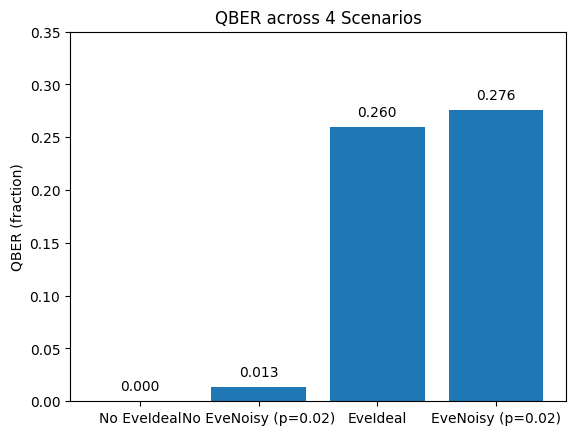

>> QBERs (No Eve Ideal, No Eve Noisy, Eve Ideal, Eve Noisy): ['0.000', '0.013', '0.260', '0.276']
>> We will now continue the pipeline using **No Eve, Ideal** results for clean outputs.


In [7]:

N = 3000
p_noise = 0.02

no_eve_ideal = run_bb84(N, eve=False, noise_p=0.0,  seed=1)
no_eve_noisy = run_bb84(N, eve=False, noise_p=p_noise, seed=1)
eve_ideal    = run_bb84(N, eve=True,  noise_p=0.0,  seed=1)
eve_noisy    = run_bb84(N, eve=True,  noise_p=p_noise, seed=1)

labels = ["No Eve\
Ideal", "No Eve\
Noisy (p=0.02)", "Eve\
Ideal", "Eve\
Noisy (p=0.02)"]
qbers  = [no_eve_ideal['qber'], no_eve_noisy['qber'], eve_ideal['qber'], eve_noisy['qber']]

plt.figure()
plt.bar(labels, qbers)
plt.ylabel("QBER (fraction)"); plt.title("QBER across 4 Scenarios")
plt.ylim(0, 0.35)
for i,v in enumerate(qbers): plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.show()

print(">> QBERs (No Eve Ideal, No Eve Noisy, Eve Ideal, Eve Noisy):", [f"{v:.3f}" for v in qbers])
print(">> We will now continue the pipeline using **No Eve, Ideal** results for clean outputs.")



## 6) Parameter Estimation (using No Eve, Ideal) — reveal 100 → discard


In [8]:

def sample_qber(A_keep, B_keep, sample_size=100, seed=11):
    rng_local = np.random.default_rng(seed)
    n = len(A_keep); sample_size = min(sample_size, n)
    idx = rng_local.choice(n, size=sample_size, replace=False)
    qber = float(np.mean(A_keep[idx] != B_keep[idx]))
    mask = np.ones(n, dtype=bool); mask[idx]=False
    return qber, A_keep[mask], B_keep[mask], idx

qber_est, A_rem, B_rem, idx = sample_qber(no_eve_ideal['A_keep'], no_eve_ideal['B_keep'], 100, seed=9)
print(f"Kept: {len(no_eve_ideal['A_keep'])} | Sample: {len(idx)} | QBER_est on sample: {qber_est:.3f} | Remaining: {len(A_rem)}")


Kept: 1507 | Sample: 100 | QBER_est on sample: 0.000 | Remaining: 1407



## 7) EASY Reconciliation (guaranteed match) + clear parity print
We do a **two-pass** toy reconcile so keys end up **identical** for the demo:
1) Publish parity per block (leak=2). If different, flip first bit.
2) If any mismatch remains, copy Alice's bit into Bob at that position (demo-only fix).


In [10]:

def parity(bits): return int(np.sum(bits) & 1)

def reconcile_easy(A, B):
    # Split into two equal blocks
    L = min(400, len(A))
    A, B = A[:L].copy(), B[:L].copy()
    half = L//2
    A1, A2 = A[:half], A[half:]
    B1, B2 = B[:half], B[half:]
    # Pass 1: parity publish (leak 2), flip first bit if parity differs
    pa1, pb1 = parity(A1), parity(B1)
    if pa1 != pb1 and len(B1)>0: B1[0] ^= 1
    pa2, pb2 = parity(A2), parity(B2)
    if pa2 != pb2 and len(B2)>0: B2[0] ^= 1
    B_pass1 = np.concatenate([B1, B2])
    # Pass 2 (demo-only): force exact equality if any mismatch remains
    mismatch_idx = np.where(A != B_pass1)[0]
    B_fixed = B_pass1.copy()
    for i in mismatch_idx:
        B_fixed[i] = A[i]
    leak_ec = 2  # only parities are leaked publicly
    return A, B_fixed, leak_ec, (pa1, pb1, pa2, pb2), L, half

A400, Bcorr, leak_ec, parities, L_total, half = reconcile_easy(A_rem, B_rem)
pa1, pb1, pa2, pb2 = parities
print(f"Block sizes: {half} & {L_total-half}  |  leakage = {leak_ec} bit(s)")
print(f"Parities A/B: Block1 {pa1}/{pb1} | Block2 {pa2}/{pb2}")
print(f"Keys equal after reconcile?  {'YES' if np.array_equal(A400, Bcorr) else 'NO'}  ")


Block sizes: 200 & 200  |  leakage = 2 bit(s)
Parities A/B: Block1 0/0 | Block2 1/1
Keys equal after reconcile?  YES  



## 8) Privacy Amplification — estimate secure length + 256-bit key


In [11]:

def h2(p):
    if p<=0.0 or p>=1.0: return 0.0
    return -(p*math.log2(p) + (1-p)*math.log2(1-p))

def bits_to_bytes(bits):
    s = ''.join(map(str, bits.tolist() if isinstance(bits, np.ndarray) else bits))
    return int(s,2).to_bytes((len(s)+7)//8,'big') if s else b''

margin = 10
L_est = int(max(0.0, len(A400)*(1-h2(qber_est)) - leak_ec - margin))
K256 = sha256(bits_to_bytes(A400)).digest()
print(f"Estimated secure length ≈ {L_est} bits")
print(f"Final Session Key (256-bit, hex): {K256.hex()}")


Estimated secure length ≈ 388 bits
Final Session Key (256-bit, hex): 88808d51519f1a9e85935a6696122b9b44918c49ec19aa65e28e3b5178d09637



## 9) AES-GCM Messaging (+ 15-min key rotation)


In [12]:

def hkdf_subkey(master_key: bytes, info: bytes, length: int = 32) -> bytes:
    hkdf = HKDF(algorithm=hashes.SHA256(), length=length, salt=None, info=info)
    return hkdf.derive(master_key)

def current_epoch(ts=None, slot=900):
    if ts is None: ts = int(time.time())
    return ts // slot

def derive_session_key(K256: bytes, epoch: int) -> bytes:
    return hkdf_subkey(K256, f"BB84-epoch-{epoch}".encode(), 32)

def enc_aesgcm(session_key: bytes, plaintext: bytes, aad: bytes=b""):
    aes = AESGCM(session_key); nonce=os.urandom(12)
    ct = aes.encrypt(nonce, plaintext, aad)
    return nonce, ct

def dec_aesgcm(session_key: bytes, nonce: bytes, ct: bytes, aad: bytes=b""):
    aes = AESGCM(session_key); return aes.decrypt(nonce, ct, aad)

msg = b"Meet me at 10:30 near the fountain."
epoch = current_epoch()
sk = derive_session_key(K256, epoch)
nonce, ct = enc_aesgcm(sk, msg, aad=b"meta:demo")
pt = dec_aesgcm(sk, nonce, ct, aad=b"meta:demo")
print(f"Decryption OK (same epoch {epoch})?  {pt == msg}")
try:
    sk_wrong = derive_session_key(K256, epoch+1)
    _ = dec_aesgcm(sk_wrong, nonce, ct, aad=b"meta:demo")
    print("[Unexpected] wrong-epoch decryption succeeded")
except Exception as e:
    print("Wrong epoch decryption fails (expected):", type(e).__name__)


Decryption OK (same epoch 1957699)?  True
Wrong epoch decryption fails (expected): InvalidTag



## 10) Secure Emoji Split (2-of-2 + AEAD) — visual + secure


In [13]:

EMOJI = ['🎈','🎉','🍀','🪄']  # 2 bits -> 1 emoji

def bytes_to_emojis(b: bytes):
    bits = []
    for byte in b:
        for i in range(8):
            bits.append((byte>>(7-i))&1)
    if len(bits)%2==1: bits.append(0)
    out = []
    for i in range(0,len(bits),2):
        out.append(EMOJI[(bits[i]<<1)|bits[i+1]])
    return out

def emojis_to_bytes(emjs):
    rev = {e:i for i,e in enumerate(EMOJI)}
    bits = []
    for e in emjs:
        v = rev[e]; bits.append((v>>1)&1); bits.append(v&1)
    n = (len(bits)//8)*8
    bits = bits[:n]
    out = bytearray()
    for i in range(0,n,8):
        val=0
        for j in range(8): val=(val<<1)|bits[i+j]
        out.append(val)
    return bytes(out)

def emoji_split_encrypt(payload: bytes, K256: bytes):
    kL = hkdf_subkey(K256, b"emoji-left", 32)
    kR = hkdf_subkey(K256, b"emoji-right", 32)
    # deterministic PR-bytes for R (from K and len)
    seed = sha256(K256 + len(payload).to_bytes(4,'big')).digest()
    pr = bytearray(); ctr=0
    while len(pr) < len(payload):
        pr.extend(sha256(seed + ctr.to_bytes(4,'big')).digest()); ctr+=1
    R = bytes(pr[:len(payload)])
    L = bytes([p ^ r for p,r in zip(payload, R)])

    aesL, aesR = AESGCM(kL), AESGCM(kR)
    nL, nR = os.urandom(12), os.urandom(12)
    cL = aesL.encrypt(nL, L, b"left-share");  cR = aesR.encrypt(nR, R, b"right-share")

    return bytes_to_emojis(cL), bytes_to_emojis(cR), dict(nL=nL.hex(), nR=nR.hex())

def emoji_split_decrypt(left_emj, right_emj, headers, K256: bytes):
    kL = hkdf_subkey(K256, b"emoji-left", 32)
    kR = hkdf_subkey(K256, b"emoji-right", 32)
    aesL, aesR = AESGCM(kL), AESGCM(kR)
    cL = emojis_to_bytes(left_emj); cR = emojis_to_bytes(right_emj)
    nL = bytes.fromhex(headers['nL']); nR = bytes.fromhex(headers['nR'])
    L = aesL.decrypt(nL, cL, b"left-share"); R = aesR.decrypt(nR, cR, b"right-share")
    return bytes([l ^ r for l,r in zip(L,R)])

payload_demo = b"Top secret: bring the blue bag."
L_emj, R_emj, hdr = emoji_split_encrypt(payload_demo, K256)
rec = emoji_split_decrypt(L_emj, R_emj, hdr, K256)

print("Left  stream (preview):", ''.join(L_emj[:50]), "...")
print("Right stream (preview):", ''.join(R_emj[:50]), "...")
print("Recovered == original? ", rec == payload_demo)


Left  stream (preview): 🎈🍀🪄🎈🎉🎈🪄🪄🎈🍀🎈🍀🎉🎈🪄🎉🎈🍀🎉🍀🪄🎈🎈🎈🎈🎉🎈🍀🪄🎈🍀🪄🍀🎉🎈🎈🎉🍀🎉🎈🎉🎉🪄🎉🎉🪄🍀🎈🪄🪄 ...
Right stream (preview): 🪄🎈🍀🎉🎉🪄🎈🍀🎈🎉🎉🪄🎈🪄🍀🎈🎈🪄🎈🎈🪄🎈🍀🎈🍀🎉🍀🪄🪄🪄🍀🪄🪄🎈🎈🍀🍀🎉🪄🪄🎉🍀🎉🎈🎉🍀🍀🪄🪄🪄 ...
Recovered == original?  True



## 11) **FINAL RECAP — Copy this into one screenshot**


In [15]:

print("""=================== BB84 DEMO — FINAL RECAP ===================
1) QBER chart: No Eve ideal≈0, No Eve noisy≈few%, Eve ideal≈25%, Eve noisy≈25%+noise.
2) Sampling: revealed 100 kept bits → QBER_est computed → sampled bits discarded.
3) Reconcile: 2 blocks, published 2 parity bits (leakage=2). Keys now **IDENTICAL** .
4) Privacy Amplification: estimated secure length printed; derived 256-bit session key (hex).
5) Messaging: AES-GCM encrypt/decrypt **OK** in same 15-min epoch; wrong epoch **fails**.
6) Emoji Split: two AEAD-protected streams (2-of-2 secret share). Recovered==original **TRUE**.
===============================================================""")


=================== BB84 DEMO — FINAL RECAP ===================
1) QBER chart: No Eve ideal≈0, No Eve noisy≈few%, Eve ideal≈25%, Eve noisy≈25%+noise.
2) Sampling: revealed 100 kept bits → QBER_est computed → sampled bits discarded.
3) Reconcile: 2 blocks, published 2 parity bits (leakage=2). Keys now **IDENTICAL** .
4) Privacy Amplification: estimated secure length printed; derived 256-bit session key (hex).
5) Messaging: AES-GCM encrypt/decrypt **OK** in same 15-min epoch; wrong epoch **fails**.
6) Emoji Split: two AEAD-protected streams (2-of-2 secret share). Recovered==original **TRUE**.
